In [1]:
#general 
import os
import argparse
import pickle

#you cannot live without 
from tqdm import trange
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
from termcolor import colored
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#pip install transformers
#pytorch related
import torch
import torch.nn as nn
import torch.nn.functional as F

#bert related
from transformers import BertModel, BertTokenizer, BertForSequenceClassification,  \
AdamW, BertConfig, get_linear_schedule_with_warmup

# self defined
from dataProcessing import GEOLiTDataProcess as GEOLit

torch.autograd.set_detect_anomaly(True)

In [41]:
geolit = GEOLit()
#then to dataloader 
train_loader, valid_loader, test_loader = geolit.dataloaderize_() #dataloader right here

length of the corpus 152066
sample of the corpus ["impaired natural killer cell self-education `` missing-self '' responses ly49-deficient mice ly49-mediated recognition mhc-i molecules host cells considered vital natural killer nk -cell regulation education however gene-deficient animal models lacking difficulty deleting large multigene family describe nk gene complex knockdown nkc kd mice lack expression ly49 related mhc-i receptors nk cells nkc kd nk cells exhibit defective killing mhc-i-deficient otherwise normal target cells resulting defective rejection nkc kd mice transplants various types mhc-i-deficient mice self-mhc-i immunosurveillance nk cells nkc kd mice rescued self-mhc-i-specific ly49 transgenes although nkc kd mice display defective recognition mhc-i-deficient tumor cells resulting decreased vivo tumor cell clearance nkg2d- antibody-dependent cell-mediated cytotoxicity-induced tumor cell cytotoxicity cytokine production induced activation receptors efficient ly49-defici

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#torch.cuda.set_device(1)
#print(torch.cuda.current_device())
print(torch.cuda.device_count())
print(device)

2
cuda


In [6]:
#Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = True # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [7]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [9]:

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_loader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [10]:
#import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

import random
import numpy as np


In [11]:
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

In [13]:
# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_loader):

        # Progress update every 40 batches.
        if step % 200 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_loader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].cuda(0)
        b_input_mask = batch[1].cuda(0)
        b_input_type_ids = batch[2].cuda(0)
        b_labels = batch[3].cuda(0)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits , _ = model(b_input_ids, 
                             token_type_ids=b_input_type_ids, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_loader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in valid_loader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].cuda(0)
        b_input_mask = batch[1].cuda(0)
        b_input_type_ids = batch[2].cuda(0)
        b_labels = batch[-1].cuda(0)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits, _) = model(b_input_ids, 
                                   token_type_ids=b_input_type_ids, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        #logits = logits.detach().cpu().numpy()\
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(valid_loader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(valid_loader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 4 ========
Training...
  Batch   200  of  6,653.    Elapsed: 0:01:28.
  Batch   400  of  6,653.    Elapsed: 0:02:57.
  Batch   600  of  6,653.    Elapsed: 0:04:25.
  Batch   800  of  6,653.    Elapsed: 0:05:53.
  Batch 1,000  of  6,653.    Elapsed: 0:07:21.
  Batch 1,200  of  6,653.    Elapsed: 0:08:49.
  Batch 1,400  of  6,653.    Elapsed: 0:10:18.
  Batch 1,600  of  6,653.    Elapsed: 0:11:46.
  Batch 1,800  of  6,653.    Elapsed: 0:13:15.
  Batch 2,000  of  6,653.    Elapsed: 0:14:43.
  Batch 2,200  of  6,653.    Elapsed: 0:16:12.
  Batch 2,400  of  6,653.    Elapsed: 0:17:40.
  Batch 2,600  of  6,653.    Elapsed: 0:19:08.
  Batch 2,800  of  6,653.    Elapsed: 0:20:36.
  Batch 3,000  of  6,653.    Elapsed: 0:22:04.
  Batch 3,200  of  6,653.    Elapsed: 0:23:31.
  Batch 3,400  of  6,653.    Elapsed: 0:24:59.
  Batch 3,600  of  6,653.    Elapsed: 0:26:27.
  Batch 3,800  of  6,653.    Elapsed: 0:27:55.
  Batch 4,000  of  6,653.    Elapsed: 0:29:23.
  Batch 4,200  of

In [80]:
print (len(train_loader) *  geolit.batch_size)
print (len(valid_loader) *  geolit.batch_size)

106448
13696


In [14]:

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
print(df_stats)
df_stats.to_csv('df_stats.csv')

       Training Loss  Valid. Loss  Valid. Accur. Training Time Validation Time
epoch                                                                         
1           2.74e-02         0.07           0.99       0:48:51         0:01:05
2           1.33e-02         0.05           0.99       0:48:53         0:01:05
3           5.15e-03         0.06           0.99       0:48:52         0:01:05
4           1.96e-03         0.06           0.99       0:48:48         0:01:05


([<matplotlib.axis.XTick at 0x7f666d1c8f98>,
 <a list of 4 Text xticklabel objects>)

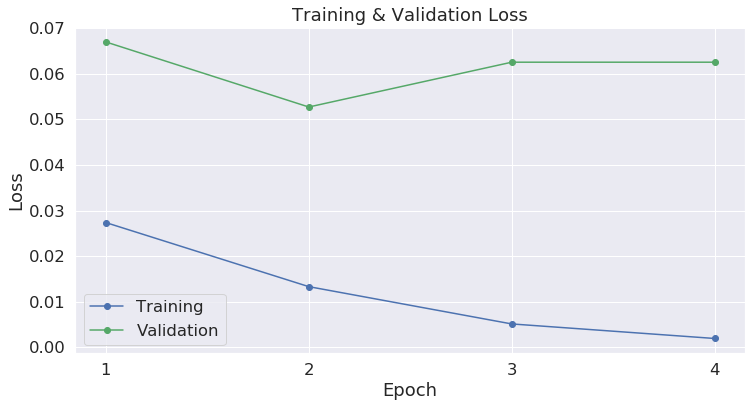

In [23]:


# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

In [66]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(test_loader1) *  geolit.batch_size ))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict
test_len = []
for batch in test_loader1:
        res = batch[0].size(0) == batch[1].size(0) == batch[2].size(0) ==  batch[-1].size(0)
        test_len.append(res)
        #print(batch[-1].size())
        #break
        # Unpack the inputs from our dataloader
        b_input_ids = batch[0].cuda(0)
        b_input_mask = batch[1].cuda(0)
        b_input_type_ids = batch[2].cuda(0)
        b_labels = batch[-1].cuda(0)

        # Telling the model not to compute or store gradients, saving memory and 
        # speeding up prediction
        with torch.no_grad():
          # Forward pass, calculate logit predictions
          (loss, logits, _) = model(b_input_ids, 
                                   token_type_ids=b_input_type_ids, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)


            #logits = outputs[0] # 0 or 1?

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 31,920 test sentences...
    DONE.


In [79]:
# Combine the results across all batches. 
combine_predictions = np.concatenate(predictions, axis=0)
# combine correct labels across all batches 
combine_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the accuracy 
accu = flat_accuracy(combine_predictions, combine_true_labels)

print('Total accuracy: %.3f' % accu)

Total accuracy: 0.991


In [44]:

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = 'model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
geolit.tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to model_save/


('model_save/vocab.txt',
 'model_save/special_tokens_map.json',
 'model_save/added_tokens.json')